# Quantum Random Number Generator (QRNG) with Qiskit

This notebook builds a true random number generator using the principles of quantum mechanics. It is executed on an `AerSimulator` from Qiskit.

In [1]:

!pip install qiskit-aer
!pip install matplotlib
!pip install pylatexenc


In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import math

## Part 1: Simulating the QRNG in Bulk

We create a simple 1-qubit circuit:
1.  A **Hadamard (H) gate** puts the qubit in an equal superposition of $|0\rangle$ and $|1\rangle$.
2.  A **Measure** operation collapses this superposition into a 0 or 1 with a theoretically 50/50 probability.

We run this on a simulator 1024 times to show the probability distribution.

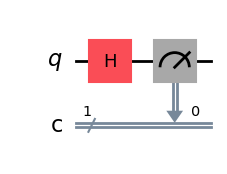

In [3]:
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

Counts for 1024 shots: {'1': 511, '0': 513}


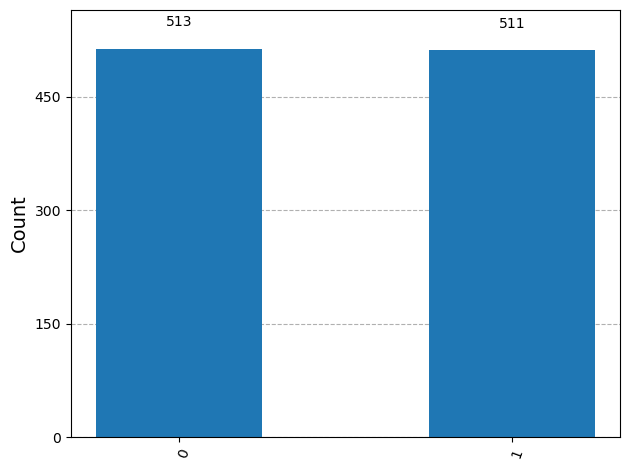

In [4]:
sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=1024).result()
counts = result.get_counts()

print("Counts for 1024 shots:", counts)
plot_histogram(counts)

## Part 2: Generating a Random Bit Sequence

We can also use the same circuit to generate a sequence of random bits one-by-one, as a real QRNG application would.

In [5]:
random_bits = []
simulator = AerSimulator()
tqc = transpile(qc, simulator) 

print("Generating 20 random bits:")
for j in range(20):        
    job = simulator.run(tqc, shots=1) 
    result = job.result()
    counts = result.get_counts()
    bit = int(list(counts.keys())[0])
    random_bits.append(bit)
    
print(random_bits)

Generating 20 random bits:
[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]


## Part 3: Analyzing the Random Bits

Are these bits *really* random? Let's generate a larger sample and run some basic statistical tests.

### 3.1: Statistical Tests

First, we'll generate 10,000 bits for our analysis.

In [6]:
N_BITS = 10000
random_bits = []

print(f"Generating {N_BITS} random bits...")
for _ in range(N_BITS):        
    job = simulator.run(tqc, shots=1) 
    result = job.result()
    counts = result.get_counts()
    bit = int(list(counts.keys())[0])
    random_bits.append(bit)

print(f"Generated {len(random_bits)} bits.")
print(f"First 50 bits: {random_bits[:50]}...")

Generating 10000 random bits...
Generated 10000 bits.
First 50 bits: [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1]...


In [7]:
def shannon_entropy(bits):
    n = len(bits)
    if n == 0:
        return 0
    prob_1 = sum(bits) / n  
    prob_0 = 1 - prob_1
    
    if prob_0 == 0 or prob_1 == 0:
        return 0 
    
    return -prob_0 * math.log2(prob_0) - prob_1 * math.log2(prob_1)

def runs_test(bits):
    n = len(bits)
    n1 = sum(bits)
    n0 = n - n1
    
    if n0 == 0 or n1 == 0:
        return 0 
    
    runs = 1
    for i in range(1, n):
        if bits[i] != bits[i-1]:
            runs += 1
            
    expected_runs = (2 * n0 * n1) / n + 1
    variance = (expected_runs - 1) * (expected_runs - 2) / (n - 1)
    if variance == 0:
        return 0
    z_score = (runs - expected_runs) / math.sqrt(variance)
    return z_score  

print(f"Analysis of {len(random_bits)} Quantum Bits")

print(f"Shannon Entropy: {shannon_entropy(random_bits):.4f} bits (Ideal: 1.0)")

count_1 = sum(random_bits)
count_0 = len(random_bits) - count_1
chi2_stat, p_value = chisquare([count_0, count_1])
print(f"Chi-square test: p-value = {p_value:.4f} (p > 0.05 is good)")

z = runs_test(random_bits)
print(f"Runs test Z-score: {z:.4f} (Good if |Z| < 1.96)")

Analysis of 10000 Quantum Bits
Shannon Entropy: 1.0000 bits (Ideal: 1.0)
Chi-square test: p-value = 0.6031 (p > 0.05 is good)
Runs test Z-score: -0.1773 (Good if |Z| < 1.96)


### 3.2: Comparison with Classical PRNG

Let's compare our quantum-generated bits with a standard classical pseudo-random number generator (PRNG) from NumPy.

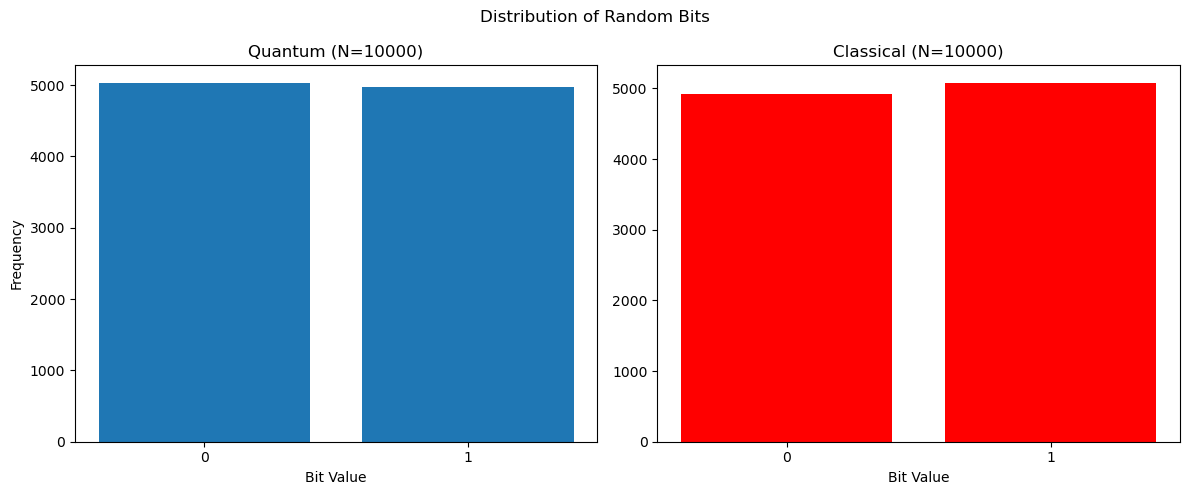

Quantum Entropy: 1.0000
Classical Entropy: 0.9998


In [8]:
classical_bits = np.random.randint(0, 2, len(random_bits))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Distribution of Random Bits')

ax1.hist(random_bits, bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.8)
ax1.set_title(f'Quantum (N={len(random_bits)})')
ax1.set_xlabel('Bit Value')
ax1.set_ylabel('Frequency')
ax1.set_xticks([0, 1])

ax2.hist(classical_bits, bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.8, color='red')
ax2.set_title(f'Classical (N={len(classical_bits)})')
ax2.set_xlabel('Bit Value')
ax2.set_xticks([0, 1])

plt.tight_layout()
plt.show()

print(f"Quantum Entropy: {shannon_entropy(random_bits):.4f}")
print(f"Classical Entropy: {shannon_entropy(classical_bits):.4f}")

## Part 4: Generating Bits in Parallel (Multi-Qubit Circuit)

Running one shot at a time is slow. We can generate $N$ bits at once by using an $N$-qubit circuit. Here, we use 4 qubits to generate 4 bits per shot. We run 1024 shots to get a total of 4096 bits.

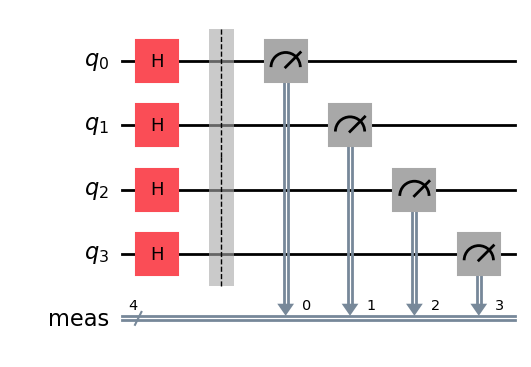

Generated 4096 bits from 4-qubit circuit.


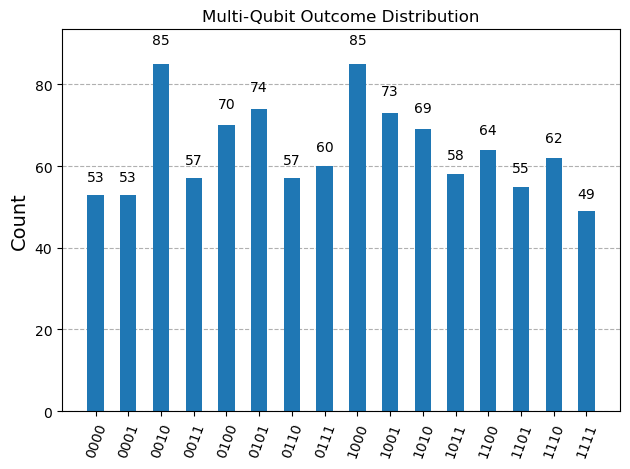

In [9]:
n_qubits = 4
qc_multi = QuantumCircuit(n_qubits)

for i in range(n_qubits):
    qc_multi.h(i)

qc_multi.measure_all()

display(qc_multi.draw('mpl'))

tqc_multi = transpile(qc_multi, simulator)
result_multi = simulator.run(tqc_multi, shots=1024).result()
counts_multi = result_multi.get_counts()

random_bits_multi = []
for outcome, count in counts_multi.items():
    cleaned_outcome = outcome.replace(' ', '')
    bits = [int(b) for b in cleaned_outcome[::-1]]
    for _ in range(count):
        random_bits_multi.extend(bits)

print(f"Generated {len(random_bits_multi)} bits from {n_qubits}-qubit circuit.")
plot_histogram(counts_multi, title="Multi-Qubit Outcome Distribution")

## Part 5: Applications of QRNG

True random numbers are crucial for cryptography, simulation, and modeling.

### 5.1: XOR Encryption (One-Time Pad)

A one-time pad is a theoretically unbreakable encryption method if the key is truly random, at least as long as the message, and never reused. We can use our `random_bits` as a (repeating) key for a simple XOR cipher.

In [10]:
def xor_encrypt(message, key_bits):
    encrypted_chars = []
    for i, char in enumerate(message):
        key_bit = key_bits[i % len(key_bits)]
        encrypted_char = chr(ord(char) ^ key_bit)
        encrypted_chars.append(encrypted_char)
    return ''.join(encrypted_chars)

message = "Hello Quantum World!"

encrypted = xor_encrypt(message, random_bits)
decrypted = xor_encrypt(encrypted, random_bits)

print(f"Original:  {message}")
print(f"Encrypted: {encrypted}")
print(f"Decrypted: {decrypted}")

Original:  Hello Quantum World!
Encrypted: Hdmmn!Qu`nuul Wnrld!
Decrypted: Hello Quantum World!


### 5.2: Monte Carlo Pi Estimation

We can use random numbers to estimate $\pi$. The idea is to randomly plot points in a 1x1 square. The ratio of points that fall *inside* a quarter-circle of radius 1 to the *total* number of points will approximate $\pi/4$.

In [11]:

def monte_carlo_pi(bits):
    inside = 0
    n_points = 0
    
    for i in range(0, len(bits) - 3, 4):
        x_bits = ''.join(map(str, bits[i:i+2]))
        y_bits = ''.join(map(str, bits[i+2:i+4]))
        
        if not x_bits or not y_bits:
            continue
            
        x = int(x_bits, 2) / 3  
        y = int(y_bits, 2) / 3  
        
        if x**2 + y**2 <= 1:
            inside += 1
        n_points += 1

    if n_points == 0:
        return 0
    
    return 4 * inside / n_points

pi_est = monte_carlo_pi(random_bits) 
print(f"Generated {len(random_bits)//4} points.")
print(f"Estimated Pi: {pi_est:.4f} (Actual: {math.pi:.4f})")

Generated 2500 points.
Estimated Pi: 2.7616 (Actual: 3.1416)
